<a href="https://colab.research.google.com/github/TechEnthusiast1TechEnthusiast/NLP-LAB-Assignments/blob/main/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative models are a class of machine learning models that generate new data instances that resemble your training data. These models can be used for various tasks, such as creating realistic images, text, or even music. In this lab assignment, we'll focus on implementing and training generative models, particularly a Variational Autoencoder (VAE) and a Generative Adversarial Network (GAN), using a simple dataset like MNIST or a text dataset for generating synthetic samples. [CO5]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

(i) Impliment Variational Autoencoder (VAE)

In [2]:
# Part 1: Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def train_vae(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)

        # Loss calculation
        reconstruction_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        loss = reconstruction_loss + kl_divergence
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')


(ii) Implement the GAN

In [3]:
# Part 2: Generative Adversarial Network (GAN)
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_gan(generator, discriminator, device, train_loader, g_optimizer, d_optimizer, epoch):
    generator.train()
    discriminator.train()

    for batch_idx, (real_data, _) in enumerate(train_loader):
        batch_size = real_data.size(0)
        real_data = real_data.view(-1, 784).to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        label_real = torch.ones(batch_size, 1).to(device)
        label_fake = torch.zeros(batch_size, 1).to(device)

        output_real = discriminator(real_data)
        d_loss_real = F.binary_cross_entropy(output_real, label_real)

        noise = torch.randn(batch_size, 100).to(device)
        fake_data = generator(noise)
        output_fake = discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(output_fake, label_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        output_fake = discriminator(fake_data)
        g_loss = F.binary_cross_entropy(output_fake, label_real)
        g_loss.backward()
        g_optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(real_data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'D_loss: {d_loss.item():.6f}\tG_loss: {g_loss.item():.6f}')


(iii) Visualize the latent space and generated images to understand how well the model captures the data distribution.

In [4]:
# Part 3: Visualization Functions
def visualize_latent_space(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        test_data, test_labels = next(iter(test_loader))
        test_data = test_data.to(device)
        mu, _ = model.encode(test_data.view(-1, 784))
        z = mu.cpu().numpy()

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=test_labels, cmap='tab10')
        plt.colorbar(scatter)
        plt.title('VAE Latent Space')
        plt.xlabel('First Latent Dimension')
        plt.ylabel('Second Latent Dimension')
        plt.show()

def visualize_generated_images(model, device, is_vae=True, num_images=10):
    model.eval()
    with torch.no_grad():
        if is_vae:
            # Generate images using VAE
            sample = torch.randn(num_images, 2).to(device)
            sample = model.decode(sample).cpu()
        else:
            # Generate images using GAN
            sample = torch.randn(num_images, 100).to(device)
            sample = model(sample).cpu()

        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        for i, ax in enumerate(axes):
            ax.imshow(sample[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.80MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.57MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training VAE...
Train Epoch: 1 [0/60000 (0%)]	Loss: 544.611511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 180.825546
Train Epoch: 1 [25600/60000 (43%)]	Loss: 170.401184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 175.365356
Train Epoch: 1 [51200/60000 (85%)]	Loss: 168.902405
Train Epoch: 2 [0/60000 (0%)]	Loss: 164.186813
Train Epoch: 2 [12800/60000 (21%)]	Loss: 157.935013
Train Epoch: 2 [25600/60000 (43%)]	Loss: 158.322281
Train Epoch: 2 [38400/60000 (64%)]	Loss: 161.431198
Train Epoch: 2 [51200/60000 (85%)]	Loss: 152.829941
Train Epoch: 3 [0/60000 (0%)]	Loss: 162.850510
Train Epoch: 3 [12800/60000 (21%)]	Loss: 162.862900
Train Epoch: 3 [25600/60000 (43%)]	Loss: 161.093628
Train Epoch: 3 [38400/60000 (64%)]	Loss: 151.231567
Train Epoch: 3 [51200/60000 (85%)]	Loss: 148.556305
Train Epoch: 4 [0/60000 (0%)]	Loss: 154.119476
Train Epoch: 4 [12800/60000 (21%)]	Loss: 147.021271
Train Epoch: 4 [25600/60000 (43%)]	Loss: 150.

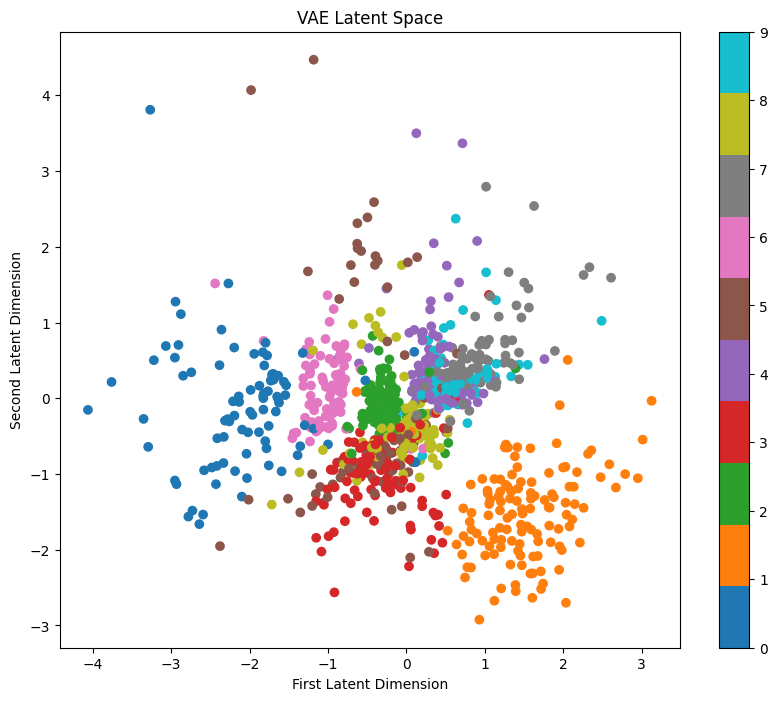


VAE generated images:


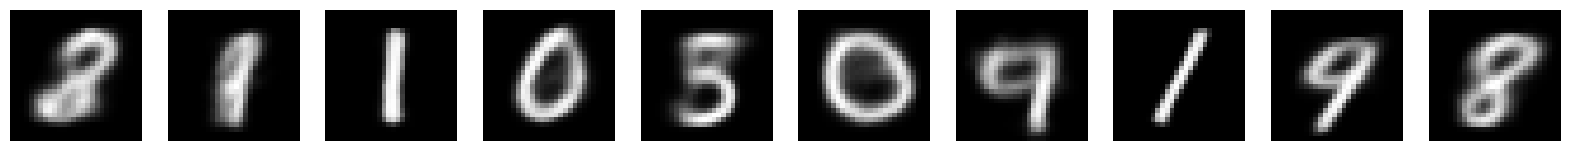


GAN generated images:


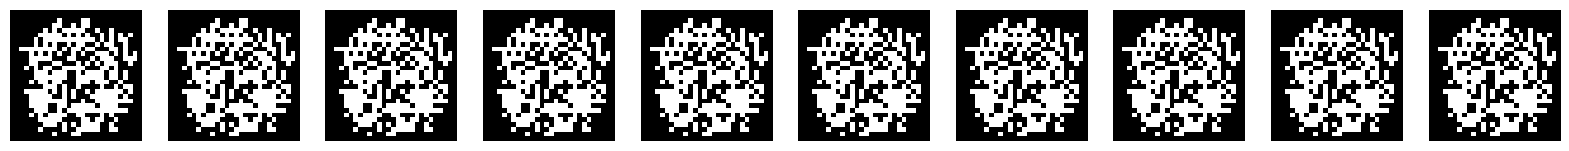

In [5]:
# Main training and visualization routine
def main():
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([transforms.ToTensor()])

    # Load MNIST dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=1000)

    # Train VAE
    vae = VAE().to(device)
    vae_optimizer = optim.Adam(vae.parameters())
    print("Training VAE...")
    for epoch in range(1, 11):
        train_vae(vae, device, train_loader, vae_optimizer, epoch)

    # Train GAN
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    g_optimizer = optim.Adam(generator.parameters())
    d_optimizer = optim.Adam(discriminator.parameters())
    print("\nTraining GAN...")
    for epoch in range(1, 11):
        train_gan(generator, discriminator, device, train_loader, g_optimizer, d_optimizer, epoch)

    # Visualizations
    print("\nGenerating visualizations...")
    visualize_latent_space(vae, test_loader, device)
    print("\nVAE generated images:")
    visualize_generated_images(vae, device, is_vae=True)
    print("\nGAN generated images:")
    visualize_generated_images(generator, device, is_vae=False)
if __name__ == "__main__":
    main()